In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [2]:
train = pd.read_csv('train.csv')

In [3]:
def prepare_data(x, to_remove=None):
    x.date_time = pd.to_datetime(x['date_time'])
    x = pd.concat([x.loc[:, ['target_carbon_monoxide', 
                             'target_benzene',
                             'target_nitrogen_oxides']], 
                  x.iloc[:, :-3]], axis=1)
    x = x.sort_values('date_time')
    x = x.set_index('date_time')
        
    return x

In [4]:
dataset = prepare_data(train).drop(['target_benzene', 'target_nitrogen_oxides'], axis=1)

In [5]:
dataset.head(2)

,target_carbon_monoxide,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
date_time,,,,,,,,,
2010-03-10 18:00:00,2.5,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4
2010-03-10 19:00:00,2.1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9


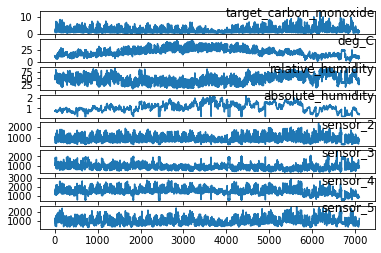

In [6]:
from matplotlib import pyplot
# load dataset
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

-----------------

In [7]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
# specify the number of lag hours
n_hours = 3
n_features = 9
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

In [9]:
# drop columns we don't want to predict
reframed.drop(['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)'], axis=1, inplace=True)
print(reframed.shape)
reframed.head(3)

(7108, 28)


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var1(t-2),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
3,0.193548,0.263393,0.452991,0.275071,0.841278,0.373362,0.330291,0.504003,0.446745,0.161290,...,0.169355,0.252232,0.577534,0.271332,0.791033,0.291757,0.332152,0.437630,0.371742,0.169355
4,0.161290,0.265625,0.444444,0.259177,0.740015,0.270401,0.392990,0.379940,0.326630,0.169355,...,0.169355,0.216518,0.653236,0.289292,0.782530,0.291447,0.351072,0.416621,0.433904,0.112903
5,0.169355,0.252232,0.577534,0.271332,0.791033,0.291757,0.332152,0.437630,0.371742,0.169355,...,0.112903,0.236607,0.611722,0.290326,0.734089,0.252089,0.385635,0.365369,0.378205,0.088710


In [10]:
#dataset.index.max() - dataset.index.min()
#print("train:", 296 * 0.8, "days", "test:", 296 * 0.2, "days")

In [11]:
# split into train and test sets
values = reframed.values
n_train_hours = 236 * 24 # 80%
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print(train.shape, test.shape)

(5664, 28) (1444, 28)


In [12]:
# split into input and outputs
n_obs = n_hours * n_features
n_obs

27

In [13]:
train_X, train_y = train[:, :n_obs], train[:, n_obs]
test_X, test_y = test[:, :n_obs], test[:, n_obs]
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(5664, 27) (1444, 27) (5664,) (1444,)


In [14]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5664, 3, 9) (5664,) (1444, 3, 9) (1444,)


Epoch 1/30
79/79 - 20s - loss: 0.0397 - val_loss: 0.0232
Epoch 2/30
79/79 - 0s - loss: 0.0101 - val_loss: 0.0182
Epoch 3/30
79/79 - 0s - loss: 0.0081 - val_loss: 0.0142
Epoch 4/30
79/79 - 0s - loss: 0.0064 - val_loss: 0.0110
Epoch 5/30
79/79 - 0s - loss: 0.0053 - val_loss: 0.0090
Epoch 6/30
79/79 - 0s - loss: 0.0047 - val_loss: 0.0081
Epoch 7/30
79/79 - 0s - loss: 0.0044 - val_loss: 0.0076
Epoch 8/30
79/79 - 0s - loss: 0.0041 - val_loss: 0.0072
Epoch 9/30
79/79 - 0s - loss: 0.0038 - val_loss: 0.0068
Epoch 10/30
79/79 - 0s - loss: 0.0035 - val_loss: 0.0064
Epoch 11/30
79/79 - 0s - loss: 0.0032 - val_loss: 0.0061
Epoch 12/30
79/79 - 0s - loss: 0.0030 - val_loss: 0.0059
Epoch 13/30
79/79 - 0s - loss: 0.0028 - val_loss: 0.0057
Epoch 14/30
79/79 - 0s - loss: 0.0026 - val_loss: 0.0056
Epoch 15/30
79/79 - 0s - loss: 0.0025 - val_loss: 0.0055
Epoch 16/30
79/79 - 0s - loss: 0.0025 - val_loss: 0.0055
Epoch 17/30
79/79 - 0s - loss: 0.0024 - val_loss: 0.0054
Epoch 18/30
79/79 - 0s - loss: 0.0024 -

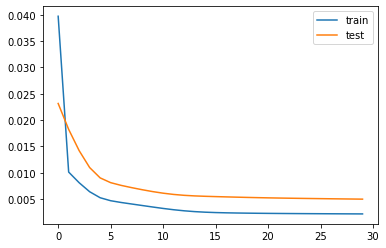

In [15]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='softplus'))
model.compile(loss='msle', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [18]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [19]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [20]:
# calculate RMSE
rmse = np.sqrt(mean_squared_log_error(inv_y, inv_yhat))
print('Test RMSLE: %.3f' % rmse)

Test RMSLE: 0.284
